In [1]:
# Author : Ameni MTIBAA
# This work was done as part of the "Big Data" class at Paris-Dauphine University
# This work was done on the Databricks Community Edition platform.

In [2]:
# This Notebook is the implementation of the proposed algorithm in "CCF: Fast and Scalable Connected Component Computation in MapReduce".
# We used the Facebook Social circles dataset : https://snap.stanford.edu/data/egonets-Facebook.html
# The purpose of the CCF algorithm here is to identify users’ social circles. In other words, find all the connected components in a given graph 

In [3]:
#Import Data
edges_1 = sc.textFile("/FileStore/tables/0.edges")
edges_2 = sc.textFile("/FileStore/tables/107.edges")
edges_3 = sc.textFile("/FileStore/tables/348.edges")
edges_4 = sc.textFile("/FileStore/tables/414.edges")
edges_5 = sc.textFile("/FileStore/tables/686.edges")
edges_6 = sc.textFile("/FileStore/tables/698.edges")
edges_7 = sc.textFile("/FileStore/tables/1684.edges")
edges_8 = sc.textFile("/FileStore/tables/1912.edges")
edges_9 = sc.textFile("/FileStore/tables/3437.edges")
edges_10 = sc.textFile("/FileStore/tables/3980.edges")

#Preprocess Data
edges = edges_1
edges = edges.union(edges_2)
edges = edges.union(edges_3)
edges = edges.union(edges_4)
edges = edges.union(edges_5)
edges = edges.union(edges_6)
edges = edges.union(edges_7)
edges = edges.union(edges_8)
edges = edges.union(edges_9)
edges = edges.union(edges_10)


edges = edges.map(lambda x : (x.split(" ")[0],x.split(" ")[1]))

#Print the number of total edges
print("total edges : ", edges.count())


total edges : 170174

In [4]:
#Create a custom accumulators class (for the list of edges)
from pyspark.accumulators import AccumulatorParam

class ListParam(AccumulatorParam):
    def zero(self, value):
        return []
    def addInPlace(self, val1, val2):
        return val1 + [val2] if type(val2) != list else val2 

# Instantiate accumulators
neighborhoodList = sc.accumulator([],ListParam())   

In [5]:
#Define CCF-Iterate Map phase
def CCF_MAP(KeyValueList): 
  KeyValueList = KeyValueList.flatMap(lambda x: (x,(x[1],x[0])))
  InputReducer = KeyValueList.groupByKey().map(lambda x : (x[0], list(x[1])))
  return InputReducer

#Define CCF-Iterate Reduce phase
def CCF_REDUCE_1(row):
  key = row[0]
  values = row[1]
  global Counter
  res = []
  valueList = []
  min_ = key
  for value in values:
    if value < min_:
      min_ = value
  if min_ < key:
    res.append((key,min_))
    for value in values:
      if min_ != value:
        Counter.add(1)
        res.append((value,min_))
  return res

def CCF_REDUCE_2(row):
  key = row[0]
  values = row[1]
  global Counter
  res = []
  valueList = []
  min_ = min(values)
  if min_ < key:
    res.append((key,min_))
    for value in values:
      if min_ != value:
        Counter.add(1)
        res.append((value,min_))
  return res

def CCF_REDUCE_3(row):
  key = row[0]
  values = row[1]
  values = sorted(values)  
  global Counter
  res = []
  valueList = []
  min_ = values[0]
  if min_ < key:
    res.append((key,min_))
    for value in values:
      if min_ != value:
        Counter.add(1)
        res.append((value,min_))
  return res

In [6]:
#CCF Algorithm (complet)
import time

iteration = 1
Counter = sc.accumulator(1)
ListeEdges = edges
neighborhoodList = sc.accumulator([],ListParam())
exectime = 0
results = []
dedup = True

while (Counter.value !=0):
  # CCF-Iterate
  startIterate = time.time()
  print("\n  Iteration : ", iteration)
  # Instantiate accumulators
  Counter = sc.accumulator(0)
  # Map
  KeyValueList = CCF_MAP(ListeEdges)
  # Reduce 
  # Remove .distinct() if you want to noDedup version
  # Change CCF_REDUCE_1 to CCF_REDUCE_2 or CCF_REDUCE_3 according to wich reduce type you want
  results = KeyValueList.flatMap(CCF_REDUCE_3).distinct()
  results.collect()
  print("Number of New Pairs created : ", Counter.value)
  iteration += 1
  ListeEdges = results
  endIterate = time.time()  
  print("CCF-Iterate execution time : ", endIterate - startIterate)
  exectime += (endIterate - startIterate)
  
print("Total execution time : ",exectime)

Iteration : 1
Number of New Pairs created : 326044
CCF-Iterate execution time : 3.964885711669922

 Iteration : 2
Number of New Pairs created : 57711
CCF-Iterate execution time : 2.0301759243011475

 Iteration : 3
Number of New Pairs created : 28309
CCF-Iterate execution time : 1.6909167766571045

 Iteration : 4
Number of New Pairs created : 13557
CCF-Iterate execution time : 1.4085471630096436

 Iteration : 5
Number of New Pairs created : 1240
CCF-Iterate execution time : 1.2536191940307617

 Iteration : 6
Number of New Pairs created : 64
CCF-Iterate execution time : 1.0051095485687256

 Iteration : 7
Number of New Pairs created : 0
CCF-Iterate execution time : 1.0551533699035645
Total execution time : 12.40840768814087

In [7]:
# REDUCE_1 and no Dedup : 20,60s
# REDUCE_2 and no Dedup : 20,49s
# REDUCE_3 and no Dedup : 20,58s
# ____________________________#
# REDUCE_1 with Dedup : 12.90s
# REDUCE_2 with Dedup : 12.60s
# REDUCE_3 with Dedup : 12.40s

In [8]:
clusters = results.map(lambda x : x[1]).distinct().collect()
print(clusters)

['244', '4001', '581', '3987', '145', '3746', '3268', '33', '3990', '2774', '2691', '0', '233']

In [9]:
%sh pip install --upgrade networkx

Requirement already up-to-date: networkx in /databricks/python3/lib/python3.7/site-packages (2.4)
Requirement already satisfied, skipping upgrade: decorator>=4.3.0 in /databricks/python3/lib/python3.7/site-packages (from networkx) (4.4.0)
You are using pip version 19.0.3, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

In [10]:
graph_edges = edges.collect()

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
color_map = []
for edge in graph_edges:
  G.add_edge(edge[0],edge[1])
for node in G:
  if node in clusters:
    color_map.append('green')
  else:
    color_map.append('red')

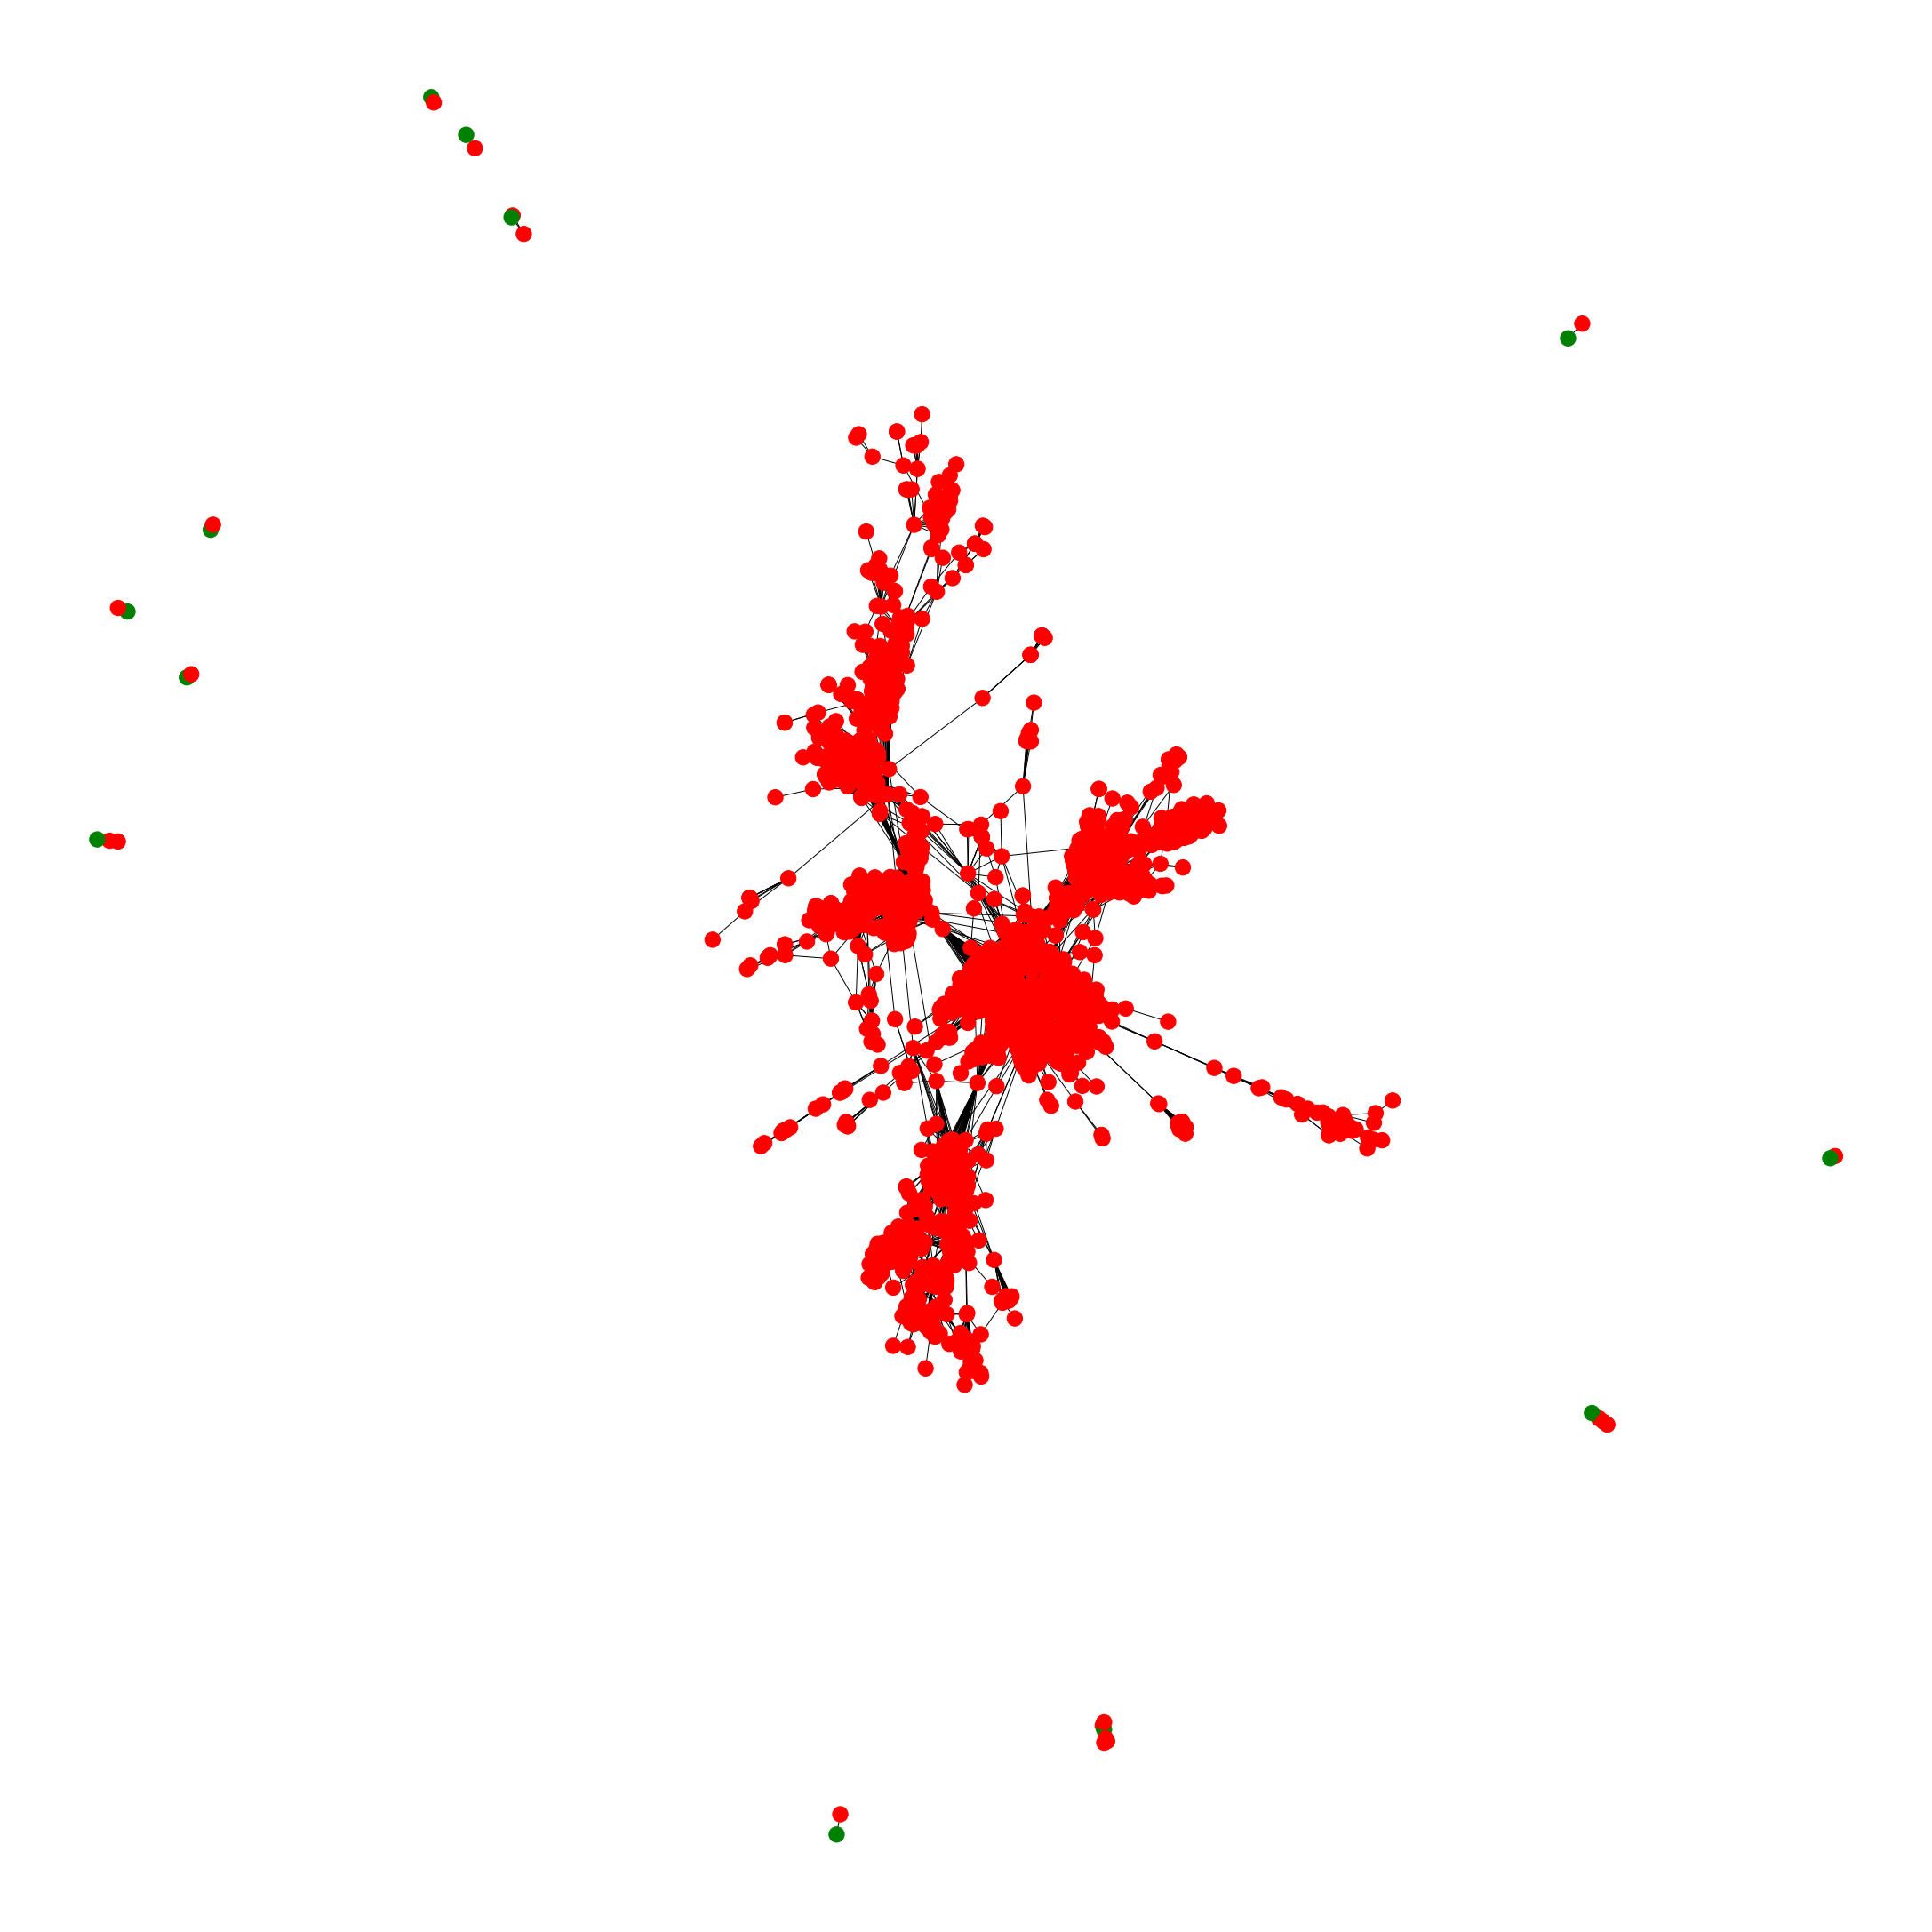

In [12]:
plt.figure(figsize=(30,30))
nx.draw(G,node_color=color_map, with_labels=False)
plt.show()